In [1]:
# %load ../src/shakel_analysis.py


import os 
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report,matthews_corrcoef
from sklearn.feature_selection import SelectFromModel
from matplotlib import pyplot as plt
import random
from math import pi
print(f"pandas version:{pd.__version__}")
print(f"numpy version:{np.__version__}")
# print(f"sklearn version:{sklearn.__version__}")

np.random.seed(101)

# #Download Data:
# !wget wget https://repository.kaust.edu.sa/bitstream/handle/10754/666961/BM5_analysis_balanced_data.csv?sequence=5&isAllowed=y
# # !wget https://repository.kaust.edu.sa/bitstream/handle/10754/666938/Clean_dataframe_balanced_all_data_ccharppi_28_march_2020_complete.csv
# !wget https://repository.kaust.edu.sa/bitstream/handle/10754/666961/BM5_analysis_unbalanced_data.csv?sequence=6&isAllowed=y

# !mkdir -p data
# !mv BM5_analysis_unbalanced_data.csv?sequence=6 data/BM5_analysis_unbalanced_data.csv
# !mv BM5_analysis_balanced_data.csv?sequence=5 data/BM5_analysis_balanced_data.csv

# !wget https://repository.kaust.edu.sa/bitstream/handle/10754/666961/BM5_analysis_balanced_data.csv?sequence=5&isAllowed=y
# !wget https://repository.kaust.edu.sa/bitstream/handle/10754/666938/Clean_dataframe_balanced_all_data_ccharppi_28_march_2020_complete.csv
# https://repository.kaust.edu.sa/bitstream/handle/10754/666961/BM5_analysis_unbalanced_data.csv?sequence=6&isAllowed=y

def save_metrics_results(model,x_test,y_test,tag):
    # target_names = ['Incorrect', 'Correct']

    y_pred = model.predict(x_test)
    cr = classification_report(y_true=y_test, y_pred=y_pred,output_dict=True)
    mmc = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
    # print (cr)
    acc = cr["accuracy"]
    rec_false = cr["False"]["recall"]
    rec_true  = cr["True"]["recall"]
    pres_false = cr["False"]["precision"]
    pres_true = cr["True"]["precision"]
    f1_false =  cr["False"]["f1-score"]
    f1_true =  cr["True"]["f1-score"]

    results = {
        "Accuracy": acc,
        "Recall_inc":rec_false,
        "Recall_cor":rec_true,
        "Precision_inc":pres_false ,
        "Precision_cor":pres_true,
        "F1_inc":f1_false,
        "F1_cor":f1_true,
        "MCC":mmc
    }
    mean_df = pd.DataFrame(data=results,index=[f"{tag}"])
    return mean_df

def train_model( choice , x_train ,y_train ):
    model = classifiers[choice ]
    return model.fit( x_train,y_train)

## source code ##
## https://python-graph-gallery.com/391-radar-chart-with-several-individuals/
def plot_radar(dataframe,title):
  # ------- PART 1: Create background
  categories = dataframe.T.index.to_list()
  # number of variable
  # categories=list(df)[1:]
  #categories = metrics_only.T["group"].values.tolist() ### original line 

  N = len(categories)
  
  # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
  angles = [n / float(N) * 2 * pi for n in range(N)]
  angles += angles[:1]
  
  # Initialise the spider plot
  ax = plt.subplot(111, polar=True)
  
  # If you want the first axis to be on top:
  ax.set_theta_offset(pi / 2)
  ax.set_theta_direction(-1)
  
  # Draw one axe per variable + add labels labels yet
  plt.xticks(angles[:-1], categories)
  
  # Draw ylabels
  ax.set_rlabel_position(0)

  plt.yticks([0,0.2,0.4,0.6,0.8,1.0], ["0","0.2","0.4","0.6","0.8","1.0"], color="grey", size=10)
  plt.ylim(0,1)
  # plt.yticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0], ["0.4","0.5","0.6","0.7","0.8","0.9","1.0"], color="grey", size=10)
  # plt.ylim(0.4,1)

  
  #------ PART 2: Add plots
  
  # Plot each individual = each line of the data
  # I don't do a loop, because plotting more than 3 groups makes the chart unreadable

  #for i,row in zip(['r','g','b'],["SVM","Perceptron","RandomForest"]):
  for i,row in zip(['r','g','b'],dataframe.index.to_list()):
      print (i,row)
      values = dataframe.loc[row].values.flatten().tolist()
      values += values[:1]
      ax.plot(angles, values, linewidth=1, linestyle='solid', label=row)
      # ax.fill(angles, values,i , alpha=0.1)


  
  # Add legend
  plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
  plt.tight_layout()
  # plt.show()
  plt.savefig(f"../figures/{title}.svg",dpi=300,transparent=True,format="svg")

pandas version:1.2.1
numpy version:1.18.5


In [2]:
PDB_CASES = [
"1A2K","1ACB","1AHW","1AK4","1AKJ","1ATN","1AVX",
"1AY7","1AZS","1B6C","1BJ1","1BKD","1BUH","1BVK",
"1BVN","1CGI","1CLV","1D6R","1DE4","1DFJ","1DQJ","1E4K","1E6E",
"1E6J","1E96","1EAW","1EER","1EFN","1EWY","1EXB",
"1F34","1F51","1FAK","1FC2","1FCC","1FFW","1FLE","1FQ1",
"1FQJ","1FSK","1GCQ","1GHQ","1GL1","1GLA","1GP2",
"1GPW","1GRN","1GXD","1H9D","1HCF","1HE1","1HE8","1HIA","1I2M",
"1I4D","1I9R","1IJK","1IQD","1J2J","1JIW","1JK9","1JPS","1JTD",
"1JTG","1JWH","1JZD","1K4C","1K5D","1K74","1KAC",
"1KKL","1KLU","1KTZ","1KXP","1KXQ","1LFD","1M27","1MAH","1ML0",
"1MLC","1MQ8","1N2C","1NCA","1NSN","1NW9","1OC0",
"1OFU","1OPH","1OYV","1PPE","1PVH","1QA9","1QFW",
"1R0R","1R6Q","1R8S","1RKE","1RLB","1RV6",
"1S1Q","1SYX","1T6B","1TMQ","1UDI","1US7","1VFB",
"1WDW","1WEJ","1WQ1","1XD3","1XQS","1XU1","1YVB",
"1Z0K","1Z5Y","1ZHH","1ZHI","1ZM4","2A1A","2A5T",
"2A9K","2ABZ","2AJF","2AYO","2B42","2B4J","2BTF","2C0L","2CFH",
"2FD6","2FJU","2G77","2GAF","2GTP","2H7V","2HLE",
"2HMI","2HQS","2HRK","2I25","2I9B","2IDO","2J0T",
"2J7P","2JEL","2MTA","2NZ8","2O3B","2O8V","2OOB",
"2OOR","2OT3","2OUL","2OZA","2PCC","2SIC",
"2SNI","2UUY","2VDB","2VXT","2W9E","2X9A","2YVJ",
"2Z0E","3A4S","3AAA","3AAD","3BIW","3BP8","3BX7",
"3CPH","3D5S","3DAW","3EO1","3EOA","3F1P",
"3FN1","3G6D","3H11","3H2V","3HI6","3HMX","3K75",
"3L5W","3LVK","3MXW","3P57","3PC8","3R9A","3RVW",
"3S9D","3SGQ","3SZK","3V6Z","3VLB","4CPA","4DN4",
"4FQI","4FZA","4G6J","4G6M","4H03","4HX3","4IZ7",
"4JCV","4LW4","4M76","7CEI","9QFW","BAAD","BOYV","BP57","CP57"
]


PDB_BM5 = [
'1EXB','1JTD','1M27','1RKE','2A1A','2GAF','2GTP','2VXT','2W9E',
'2X9A','2YVJ','3A4S','3AAA','BAAD','3AAD','3BIW','3BX7',
'3DAW','3EO1','3EOA','3F1P','3FN1','3G6D','3H11',
'3H2V','3HI6','3HMX','3K75','3L5W','3L89','3LVK','3MXW',
'BP57','CP57','3P57','3PC8','3R9A','3RVW','3S9D','3SZK',
'3V6Z','3VLB','4DN4','4FQI','4FZA','4G6J','4G6M','4GAM',
'4GXU','4H03','4HX3','4IZ7','4JCV','4LW4','4M76'
]

feature_list_a = []

In [3]:
all_balanced_data = pd.read_csv("../data/Clean_dataframe_balanced_all_data_ccharppi_4_march_2020_complete.csv",dtype={'class_q': 'object'})
all_unbalanced_data = pd.read_csv("../data/Clean_dataframe_unbalanced_all_data_ccharppi_4_march_2020_complete.csv",dtype={'class_q': 'object'})


all_balanced_data.rename(columns={'NIS Polar' :'Nis_Polar',
                                  'Nis Apolar':'Nis_Apolar',
                                  'BSA Apolar':'BSA_Apolar',
                                  'BSA Polar' :'BSA_Polar'},inplace=True)


all_unbalanced_data.rename(columns={'Unnamed: 0':'Conf',
                                  'NIS Polar' :'Nis_Polar',
                                  'Nis Apolar':'Nis_Apolar',
                                  'BSA Apolar':'BSA_Apolar',
                                  'BSA Polar' :'BSA_Polar'},inplace=True)

all_balanced_data.set_index("Conf",inplace=True)

all_unbalanced_data.set_index("Conf",inplace=True)


# feat_object = ['idx','class_q','label_binary','DQ_val','RFC', 'NNC', 'TF2']
feat_object = ['idx','class_q','label_binary','DQ_val']

## correct the only point with the mean value 
all_balanced_data.loc["Z_1JTG_1136_M.pdb","DDG_V"]  = all_balanced_data["DDG_V"].mean()
all_unbalanced_data.loc["Z_1JTG_1136_M.pdb","DDG_V"]  = all_balanced_data["DDG_V"].mean()


all_pdb = all_balanced_data["idx"].unique()

number_of_solutions = all_balanced_data[all_balanced_data["label_binary"] == 1.0].groupby(by="idx").count()["label_binary"]

number_of_solutions = number_of_solutions.sort_values()

pdb_10_solution = number_of_solutions[number_of_solutions <= 10 ].index.values



all_pdb_more_than_10_sol =list(set(all_pdb) - set(pdb_10_solution))


C = 10

# Create different classifiers.
classifiers = {

    'RandomForest': RandomForestClassifier(n_jobs=-1 ,n_estimators=100, random_state=32 ),
    'perceptron': MLPClassifier(activation='relu',random_state=32  ),
    'svc':SVC(kernel="sigmoid",C=C, probability=True,random_state=32),

}

# Accuracy = []
# Precision, Precision_1 , Precision_0 = [],[],[]
# Recall , Recall_1 , Recall_0 = [],[],[]
# MCC = []

# list_results_rfc, list_results_svm , list_results_prc = [], [] ,[]
# Train_size , Test_set  = [] , []

X_train = all_balanced_data[~all_balanced_data["idx"].isin(PDB_BM5) ]
y_train = all_balanced_data[~all_balanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')
X_validation = all_balanced_data[all_balanced_data["idx"].isin(PDB_BM5) ]
y_validation = all_balanced_data[all_balanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')

scaler = StandardScaler( )
scaler.fit(X_train.drop(feat_object,axis=1))

X_train_scaled = scaler.transform(X_train.drop(feat_object,axis=1))
X_validation_scaled = scaler.transform(X_validation[X_train.drop(feat_object,axis=1).columns])

# Commented out IPython magic to ensure Python compatibility.
# %%time
rfc = train_model( 'RandomForest', X_train_scaled ,y_train)
prc = train_model('perceptron' , X_train_scaled ,y_train)
# 
#

# Commented out IPython magic to ensure Python compatibility.
# %%time
svm = train_model('svc' , X_train_scaled ,y_train )

results_rfc = save_metrics_results(rfc, X_validation_scaled, y_validation,"RFC")
results_svm = save_metrics_results(svm, X_validation_scaled, y_validation,"SVM")
results_prc = save_metrics_results(prc, X_validation_scaled, y_validation,"PRC")

df_metrics_balanced = pd.concat([results_rfc,results_prc,results_svm])

print (df_metrics_balanced.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Accuracy &  Recall\_inc &  Recall\_cor &  Precision\_inc &  Precision\_cor &    F1\_inc &    F1\_cor &       MCC \\
\midrule
RFC &  0.832070 &    0.866860 &    0.797279 &       0.810467 &       0.856903 &  0.837716 &  0.826017 &  0.665753 \\
PRC &  0.817406 &    0.824487 &    0.810326 &       0.812974 &       0.821966 &  0.818690 &  0.816104 &  0.634876 \\
SVM &  0.716715 &    0.685772 &    0.747658 &       0.731012 &       0.704085 &  0.707669 &  0.725218 &  0.434262 \\
\bottomrule
\end{tabular}



In [4]:
#lest start wit the unbalanced

X_validation = all_unbalanced_data[all_unbalanced_data["idx"].isin(PDB_BM5) ]
y_validation = all_unbalanced_data[all_unbalanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')
X_validation_scaled = scaler.transform(X_validation[X_train.drop(feat_object,axis=1).columns])

results_rfc = save_metrics_results(rfc, X_validation_scaled, y_validation,"RFC")
results_prc = save_metrics_results(prc, X_validation_scaled, y_validation,"PRC")
results_svm = save_metrics_results(svm, X_validation_scaled, y_validation,"SVM")

df_metrics_unbalanced = pd.concat([results_rfc,results_prc,results_svm])

print (df_metrics_unbalanced.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Accuracy &  Recall\_inc &  Recall\_cor &  Precision\_inc &  Precision\_cor &    F1\_inc &    F1\_cor &       MCC \\
\midrule
RFC &  0.910165 &    0.919108 &    0.793426 &       0.983074 &       0.429026 &  0.950015 &  0.556914 &  0.541881 \\
PRC &  0.862569 &    0.863670 &    0.848210 &       0.986715 &       0.322780 &  0.921101 &  0.467613 &  0.469386 \\
SVM &  0.712164 &    0.705598 &    0.797880 &       0.978527 &       0.171923 &  0.819947 &  0.282890 &  0.275224 \\
\bottomrule
\end{tabular}



In [5]:
# Commented out IPython magic to ensure Python compatibility.
# %%time
np.random.seed(101)
kfold_val_rfc = []
sample_size_balanced = []
sample_size_unbalanced = []

for fold in range(10):
    print (fold,end=" ")
    choice = random.choices(all_balanced_data['idx'].unique(), k=64)
    x_train = all_balanced_data[~all_balanced_data["idx"].isin(choice) ]
    y_train= all_balanced_data[~all_balanced_data["idx"].isin(choice) ]["label_binary"].astype('bool')
    x_val = all_balanced_data[all_balanced_data["idx"].isin(choice) ]
    y_val =all_balanced_data[all_balanced_data["idx"].isin(choice) ]["label_binary"].astype('bool')
    scaler = StandardScaler( )
    scaler.fit(x_train.drop(feat_object,axis=1))
    x_train_scaled = scaler.transform(x_train.drop(feat_object,axis=1))
    x_validation_scaled = scaler.transform(x_val[x_train.drop(feat_object,axis=1).columns])
    sample_size_balanced.append(x_validation_scaled.shape[0])

    rfc = train_model( 'RandomForest', x_train_scaled ,y_train)
    results_rfc = save_metrics_results(rfc, X_validation_scaled, y_validation,f'{fold}')
    kfold_val_rfc.append(results_rfc)
#
print()
print("this is the result of CV over balanced dataset BM5")
kfold_dataframe = pd.concat(kfold_val_rfc)

#this is the result of CR over balanced dataset 
for cols in kfold_dataframe.columns:
    m, s = kfold_dataframe[cols].mean() , kfold_dataframe[cols].std() 
    print (f'{cols}\t {m:.4f}\t {s:.4f}')
print()
# Commented out IPython magic to ensure Python compatibility.
# %%time
# np.random.seed(101)
kfold_val_rfc = []
kfold_features_importances_rfc = []
cols = X_train.drop(feat_object,axis=1).columns 
for fold in range(10):
    print (fold,end=" ")
    choice = random.choices(all_balanced_data['idx'].unique(), k=64)
    x_train = all_balanced_data[~all_balanced_data["idx"].isin(choice) ]
    y_train= all_balanced_data[~all_balanced_data["idx"].isin(choice) ]["label_binary"].astype('bool')
    x_val = all_unbalanced_data[all_unbalanced_data["idx"].isin(choice) ]
    y_val = all_unbalanced_data[all_unbalanced_data["idx"].isin(choice) ]["label_binary"].astype('bool')
    scaler = StandardScaler( )
    scaler.fit(x_train.drop(feat_object,axis=1))
    x_train_scaled = scaler.transform(x_train.drop(feat_object,axis=1))
    x_validation_scaled = scaler.transform(x_val[x_train.drop(feat_object,axis=1).columns])
    sample_size_unbalanced.append(x_validation_scaled.shape[0] )


    rfc = train_model( 'RandomForest', x_train_scaled ,y_train)
    results_rfc = save_metrics_results(rfc, X_validation_scaled, y_validation,f"{fold}")
    feature_importances = pd.DataFrame(zip (cols, rfc.feature_importances_))
    feature_importances.columns = ['SF',f'Imp_{fold}']
    feature_importances.set_index('SF',inplace=True)
    kfold_val_rfc.append(results_rfc)
    kfold_features_importances_rfc.append(feature_importances)
print()
print("this is the result of CV over unbalanced dataset all BM5  ")
kfold_dataframe_u = pd.concat(kfold_val_rfc)
#this is the result of CR over unbalanced dataset 
for cols in kfold_dataframe_u.columns:
    m, s = kfold_dataframe_u[cols].mean() , kfold_dataframe_u[cols].std() 
    print (f'{cols}\t {m:.4f}\t {s:.4f}')

kfold_feat_imp = pd.concat(kfold_features_importances_rfc,axis=1)

kfold_feat_imp["mean Imp u"]= kfold_feat_imp.mean(axis=1)
kfold_feat_imp["std Imp u"]= kfold_feat_imp.std(axis=1)

kfold_feat_imp.sort_values(by="mean Imp u",inplace=True,ascending=False)

#train under cross validation eval unb
# feature_list_a.append(kfold_feat_imp[kfold_feat_imp['mean Imp'] > 0.01][['mean Imp','std Imp']])
feature_list_a.append(kfold_feat_imp[['mean Imp u','std Imp u']])

len(feature_list_a)

# print ( kfold_feat_imp[kfold_feat_imp['mean Imp u'] > 0.01][['mean Imp u','std Imp u']].to_latex() )
print ( kfold_feat_imp[['mean Imp u','std Imp u']].to_latex() )

0 1 2 3 4 5 6 7 8 9 
this is the result of CV over balanced dataset BM5
Accuracy	 0.9551	 0.0107
Recall_inc	 0.9619	 0.0045
Recall_cor	 0.8665	 0.1003
Precision_inc	 0.9895	 0.0079
Precision_cor	 0.6340	 0.0524
F1_inc	 0.9755	 0.0058
F1_cor	 0.7319	 0.0697
MCC	 0.7186	 0.0787

0 1 2 3 4 5 6 7 8 9 
this is the result of CV over unbalanced dataset all BM5  
Accuracy	 0.9594	 0.0086
Recall_inc	 0.9613	 0.0061
Recall_cor	 0.9344	 0.0519
Precision_inc	 0.9948	 0.0041
Precision_cor	 0.6500	 0.0455
F1_inc	 0.9777	 0.0048
F1_cor	 0.7664	 0.0468
MCC	 0.7598	 0.0511
\begin{tabular}{lrr}
\toprule
{} &  mean Imp u &  std Imp u \\
SF             &             &            \\
\midrule
CONSRANK\_val   &    0.198746 &   0.007182 \\
CP\_HLPL        &    0.024261 &   0.001846 \\
CP\_MJ3h        &    0.024073 &   0.003045 \\
PYDOCK\_TOT     &    0.022669 &   0.002977 \\
DDG\_V          &    0.022088 &   0.002516 \\
CP\_SKOIP       &    0.021770 &   0.003223 \\
ELE            &    0.018424 &   0.001062 \\

In [9]:
kfold_dataframe_u["Size"] = sample_size_unbalanced

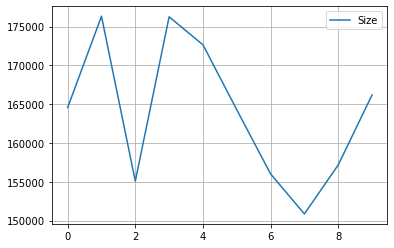

In [10]:
f= kfold_dataframe_u.T.loc["Size"].plot(grid=True,legend="Size")
f.set_xlabel("Fold")
f.set_ylabel("Total # of samples")
plt.savefig("../figures/CV_unbalanced_each_size.png",format="png")

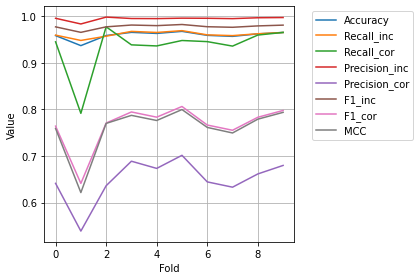

In [11]:
f= kfold_dataframe_u.drop("Size",axis=1).plot(grid=True)
f.set_xlabel("Fold")
f.set_ylabel("Value")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../figures/CV_unbalanced_each_fold_metrics.png",format="png")

In [12]:
kfold_dataframe["Size"] = sample_size_balanced

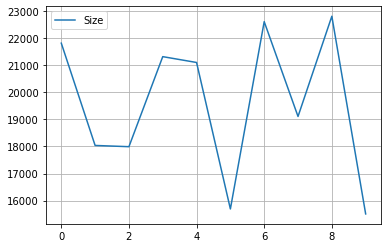

In [13]:
f=kfold_dataframe.T.loc["Size"].plot(grid=True,legend="Size")
f.set_xlabel("Fold")
f.set_ylabel("Total # of samples")
plt.savefig("../figures/CV_balanced_each_size.png",format="png")

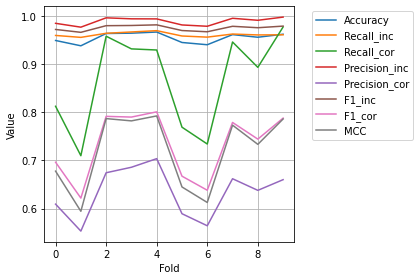

In [14]:
f = kfold_dataframe.drop("Size",axis=1).plot(grid=True)
f.set_xlabel("Fold")
f.set_ylabel("Value")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../figures/CV_balanced_each_fold_metrics.png",format="png")

In [15]:
# Commented out IPython magic to ensure Python compatibility.
# %%time
X_train = all_balanced_data[~all_balanced_data["idx"].isin(PDB_BM5) ]
y_train = all_balanced_data[~all_balanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')
X_validation = all_balanced_data[all_balanced_data["idx"].isin(PDB_BM5) ]
y_validation = all_balanced_data[all_balanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')
scaler = StandardScaler( )
scaler.fit(X_train.drop(feat_object,axis=1))
X_train_scaled = scaler.transform(X_train.drop(feat_object,axis=1))
X_validation_scaled = scaler.transform(X_validation[X_train.drop(feat_object,axis=1).columns])
rfc = train_model( 'RandomForest', X_train_scaled ,y_train)

#train BM4 and eval bal BM5
feature_importances = pd.DataFrame(zip (X_train.drop(feat_object,axis=1).columns , rfc.feature_importances_))
feature_importances.columns = ['SF','Imp']
feature_importances.set_index('SF',inplace=True)
feature_importances.sort_values(by="Imp",inplace=True,ascending=False)
feature_list_a.append(feature_importances)

print (feature_importances.to_latex())

\begin{tabular}{lr}
\toprule
{} &       Imp \\
SF             &           \\
\midrule
CONSRANK\_val   &  0.205553 \\
AP\_GOAP\_DF     &  0.027491 \\
CP\_TD          &  0.024703 \\
CP\_D1          &  0.023990 \\
DDG\_V          &  0.022467 \\
CP\_HLPL        &  0.022461 \\
CP\_MJ3h        &  0.022400 \\
PYDOCK\_TOT     &  0.022311 \\
ELE            &  0.017685 \\
CP\_SKOIP       &  0.017183 \\
CP\_MJ2h        &  0.016964 \\
SIPPER         &  0.014901 \\
AP\_DFIRE2      &  0.012938 \\
AP\_dDFIRE      &  0.011970 \\
AP\_PISA        &  0.011819 \\
CP\_TSC         &  0.010130 \\
CP\_RMFCA       &  0.010124 \\
PROPNSTS       &  0.009757 \\
CP\_TB          &  0.009338 \\
CP\_BT          &  0.008314 \\
AP\_calRWp      &  0.008179 \\
CP\_RMFCEN1     &  0.008149 \\
Nis\_Polar      &  0.007890 \\
CP\_TEl         &  0.007648 \\
AP\_DARS        &  0.007462 \\
ZRANK          &  0.007375 \\
BSA\_Apolar     &  0.007298 \\
CP\_ES3DC\_MIN   &  0.006455 \\
AP\_calRW       &  0.006179 \\
BSA            & 

In [16]:
# Commented out IPython magic to ensure Python compatibility.
# %%time
# X_train = all_balanced_data[~all_balanced_data["idx"].isin(PDB_BM5) ]
# y_train = all_balanced_data[~all_balanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')
# X_validation = all_unbalanced_data[all_unbalanced_data["idx"].isin(PDB_BM5) ]
# y_validation = all_unbalanced_data[all_unbalanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')
# scaler = StandardScaler( )
# scaler.fit(X_train.drop(feat_object,axis=1))
# X_train_scaled = scaler.transform(X_train.drop(feat_object,axis=1))
# X_validation_scaled = scaler.transform(X_validation[X_train.drop(feat_object,axis=1).columns])
# rfc = train_model( 'RandomForest', X_train_scaled ,y_train)

# train BM4 and eval unb BM5
  # feature_importances = pd.DataFrame(zip (X_train.drop(feat_object,axis=1).columns , rfc.feature_importances_))
  # feature_importances.columns = ['SF','Imp']
  # feature_importances.set_index('SF',inplace=True)
  # feature_importances.sort_values(by="Imp",inplace=True,ascending=False)
  # feature_list_a.append(feature_importances[feature_importances[ 'Imp'] > 0.01])
  #feature_list_a.append(feature_importances)

#print (feature_importances[feature_importances[ 'Imp'] > 0.01].to_latex())

#all_unbalanced_data.label_binary.value_counts()[1] /all_unbalanced_data.shape[0]

# my_list = []
# for idx in all_unbalanced_data.idx.unique():
#   x = all_unbalanced_data[all_unbalanced_data['idx'] == idx].label_binary.value_counts()[1] /all_unbalanced_data[all_unbalanced_data['idx'] == idx].shape[0]
#   if x <= 0.05 :
#     my_list.append(idx)

    
number_of_solutions = all_balanced_data[all_balanced_data["label_binary"] == 1.0].groupby(by="idx").count()["label_binary"]

number_of_solutions = number_of_solutions.sort_values()

my_list = number_of_solutions[(number_of_solutions/3000 *100) <= 5.0].index.values.tolist()


In [17]:
np.random.seed(101)
kfold_val_rfc = []
kfold_features_importances_rfc = []
cols = X_train.drop(feat_object,axis=1).columns 
for fold in range(10):
    print (fold,end=" ")
    choice = random.choices(my_list, k=50)
    x_train = all_balanced_data[~all_balanced_data["idx"].isin(choice) ]
    y_train= all_balanced_data[~all_balanced_data["idx"].isin(choice) ]["label_binary"].astype('bool')
    x_val = all_unbalanced_data[all_unbalanced_data["idx"].isin(choice) ]
    y_val = all_unbalanced_data[all_unbalanced_data["idx"].isin(choice) ]["label_binary"].astype('bool')
    scaler = StandardScaler( )
    scaler.fit(x_train.drop(feat_object,axis=1))
    x_train_scaled = scaler.transform(x_train.drop(feat_object,axis=1))
    x_validation_scaled = scaler.transform(x_val[x_train.drop(feat_object,axis=1).columns])

    rfc = train_model( 'RandomForest', x_train_scaled ,y_train)
    results_rfc = save_metrics_results(rfc, x_validation_scaled, y_validation,f"{fold}")
    feature_importances = pd.DataFrame(zip (cols, rfc.feature_importances_))
    feature_importances.columns = ['SF',f'Imp_{fold}']
    feature_importances.set_index('SF',inplace=True)
    kfold_val_rfc.append(results_rfc)
    kfold_features_importances_rfc.append(feature_importances)

print("this is the result of CV over unbalanced dataset hard")
kfold_dataframe_h = pd.concat(kfold_val_rfc)
#this is the result of CR over unbalanced dataset 
for cols in kfold_dataframe_h.columns:
  m, s = kfold_dataframe_h[cols].mean() , kfold_dataframe_h[cols].std() 
  print (f'{cols}\t {m:.4f}\t {s:.4f}')

#unb hard
kfold_feat_imp = pd.concat(kfold_features_importances_rfc,axis=1)
kfold_feat_imp["mean Imp h"]= kfold_feat_imp.mean(axis=1)
kfold_feat_imp["std Imp h"]= kfold_feat_imp.std(axis=1)
kfold_feat_imp.sort_values(by="mean Imp h",inplace=True,ascending=False)

feature_list_a.append(kfold_feat_imp[['mean Imp h','std Imp h']])

print(kfold_feat_imp[['mean Imp h','std Imp h']].to_latex())

0 1 2 3 4 5 6 7 8 9 this is the result of CV over unbalanced dataset hard
Accuracy	 0.9790	 0.0040
Recall_inc	 0.9920	 0.0011
Recall_cor	 0.9661	 0.0080
Precision_inc	 0.9670	 0.0075
Precision_cor	 0.9918	 0.0011
F1_inc	 0.9793	 0.0039
F1_cor	 0.9788	 0.0041
MCC	 0.9584	 0.0078
\begin{tabular}{lrr}
\toprule
{} &  mean Imp h &  std Imp h \\
SF             &             &            \\
\midrule
CONSRANK\_val   &    0.209530 &   0.006846 \\
CP\_MJ3h        &    0.025357 &   0.001167 \\
CP\_HLPL        &    0.024997 &   0.001192 \\
CP\_SKOIP       &    0.024238 &   0.001500 \\
PYDOCK\_TOT     &    0.023614 &   0.001397 \\
DDG\_V          &    0.022802 &   0.001269 \\
ELE            &    0.017799 &   0.000768 \\
SIPPER         &    0.016599 &   0.001296 \\
CP\_D1          &    0.016012 &   0.001297 \\
CP\_TB          &    0.015343 &   0.001342 \\
AP\_GOAP\_DF     &    0.015106 &   0.000629 \\
AP\_PISA        &    0.013770 &   0.001322 \\
CP\_TD          &    0.013002 &   0.000784 \\
CP\_RMF

In [18]:
np.random.seed(101)
kfold_val_rfc = []
# kfold_features_importances_rfc = []
cols = X_train.drop(feat_object,axis=1).columns 
for fold in range(10):
  print (fold,end=" ")
  choice = random.choices(my_list, k=50)
  x_train = all_balanced_data[~all_balanced_data["idx"].isin(choice) ]
  y_train= all_balanced_data[~all_balanced_data["idx"].isin(choice) ]["label_binary"].astype('bool')
  x_val = all_balanced_data[all_balanced_data["idx"].isin(choice) ]
  y_val = all_balanced_data[all_balanced_data["idx"].isin(choice) ]["label_binary"].astype('bool')
  scaler = StandardScaler( )
  scaler.fit(x_train.drop(feat_object,axis=1))
  x_train_scaled = scaler.transform(x_train.drop(feat_object,axis=1))
  x_validation_scaled = scaler.transform(x_val[x_train.drop(feat_object,axis=1).columns])

  rfc = train_model( 'RandomForest', x_train_scaled ,y_train)
  results_rfc = save_metrics_results(rfc, X_validation_scaled, y_validation,f"{fold}")
  # feature_importances = pd.DataFrame(zip (cols, rfc.feature_importances_))
  # feature_importances.columns = ['SF',f'Imp_{fold}']
  # feature_importances.set_index('SF',inplace=True)
  kfold_val_rfc.append(results_rfc)
  # kfold_features_importances_rfc.append(feature_importances)
print()
kfold_dataframe_hb = pd.concat(kfold_val_rfc)
#this is the result of CR over unbalanced dataset 
for cols in kfold_dataframe_hb.columns:
  m, s = kfold_dataframe_hb[cols].mean() , kfold_dataframe_hb[cols].std() 
  print (f'{cols}\t {m:.4f}\t {s:.4f}')

0 1 2 3 4 5 6 7 8 9 
Accuracy	 0.9772	 0.0043
Recall_inc	 0.9919	 0.0008
Recall_cor	 0.9626	 0.0082
Precision_inc	 0.9637	 0.0077
Precision_cor	 0.9916	 0.0009
F1_inc	 0.9776	 0.0042
F1_cor	 0.9769	 0.0045
MCC	 0.9549	 0.0084


In [19]:
# pd.concat( [kfold_dataframe_u ,  kfold_dataframe] , axis=0) 
kfold_list = {}
kfold_list_hard = {}
for cols in kfold_dataframe_h.columns:
  m, s = kfold_dataframe_h[cols].mean() , kfold_dataframe_h[cols].std() 
  u ,v = kfold_dataframe_u[cols].mean(), kfold_dataframe_u[cols].std()
  x ,y = kfold_dataframe[cols].mean(), kfold_dataframe[cols].std()
  f, g = kfold_dataframe_hb[cols].mean() , kfold_dataframe_hb[cols].std()
  kfold_list[cols] = {   "Balan":f'{x:.4f} $\pm$ {y:.4f}', "Unbal":f'{u:.4f} $\pm$ {v:.4f}' ,}
  kfold_list_hard[cols] = { "Hard bal":f'{f:.4f} $\pm$ {g:.4f}', "Hard umb":f'{m:.4f} $\pm$ {s:.4f}'  }
  # print (f'{cols}\t {m:.4f}\t {s:.4f}')

print (pd.DataFrame.from_dict( kfold_list).T.to_latex())

\begin{tabular}{lll}
\toprule
{} &                Balan &                Unbal \\
\midrule
Accuracy      &  0.9551 \$\textbackslash pm\$ 0.0107 &  0.9594 \$\textbackslash pm\$ 0.0086 \\
Recall\_inc    &  0.9619 \$\textbackslash pm\$ 0.0045 &  0.9613 \$\textbackslash pm\$ 0.0061 \\
Recall\_cor    &  0.8665 \$\textbackslash pm\$ 0.1003 &  0.9344 \$\textbackslash pm\$ 0.0519 \\
Precision\_inc &  0.9895 \$\textbackslash pm\$ 0.0079 &  0.9948 \$\textbackslash pm\$ 0.0041 \\
Precision\_cor &  0.6340 \$\textbackslash pm\$ 0.0524 &  0.6500 \$\textbackslash pm\$ 0.0455 \\
F1\_inc        &  0.9755 \$\textbackslash pm\$ 0.0058 &  0.9777 \$\textbackslash pm\$ 0.0048 \\
F1\_cor        &  0.7319 \$\textbackslash pm\$ 0.0697 &  0.7664 \$\textbackslash pm\$ 0.0468 \\
MCC           &  0.7186 \$\textbackslash pm\$ 0.0787 &  0.7598 \$\textbackslash pm\$ 0.0511 \\
\bottomrule
\end{tabular}



In [20]:
print (pd.DataFrame.from_dict( kfold_list_hard).T.to_latex())

\begin{tabular}{lll}
\toprule
{} &             Hard bal &             Hard umb \\
\midrule
Accuracy      &  0.9772 \$\textbackslash pm\$ 0.0043 &  0.9790 \$\textbackslash pm\$ 0.0040 \\
Recall\_inc    &  0.9919 \$\textbackslash pm\$ 0.0008 &  0.9920 \$\textbackslash pm\$ 0.0011 \\
Recall\_cor    &  0.9626 \$\textbackslash pm\$ 0.0082 &  0.9661 \$\textbackslash pm\$ 0.0080 \\
Precision\_inc &  0.9637 \$\textbackslash pm\$ 0.0077 &  0.9670 \$\textbackslash pm\$ 0.0075 \\
Precision\_cor &  0.9916 \$\textbackslash pm\$ 0.0009 &  0.9918 \$\textbackslash pm\$ 0.0011 \\
F1\_inc        &  0.9776 \$\textbackslash pm\$ 0.0042 &  0.9793 \$\textbackslash pm\$ 0.0039 \\
F1\_cor        &  0.9769 \$\textbackslash pm\$ 0.0045 &  0.9788 \$\textbackslash pm\$ 0.0041 \\
MCC           &  0.9549 \$\textbackslash pm\$ 0.0084 &  0.9584 \$\textbackslash pm\$ 0.0078 \\
\bottomrule
\end{tabular}



In [21]:
importance_by_train  = pd.concat(feature_list_a,axis =1,sort=True)

In [22]:
importance_by_train

,mean Imp u,std Imp u,Imp,mean Imp h,std Imp h
SF,,,,,
AA,0.001007,0.000090,0.001044,0.001005,0.000069
AA_sqrt,0.000999,0.000068,0.001047,0.001024,0.000057
AAl,0.001228,0.000070,0.001283,0.001202,0.000057
AAl_sqrt,0.001238,0.000066,0.001284,0.001153,0.000053
AAr,0.002007,0.000372,0.002753,0.001592,0.000045
...,...,...,...,...,...
cips_CP,0.002921,0.000157,0.002914,0.002922,0.000135
cips_PA,0.003483,0.000155,0.003370,0.003276,0.000115
cips_PAl,0.002766,0.000114,0.002738,0.002578,0.000077


In [23]:
importance_by_train.columns = ['Imp CV BM5','std CV BM5','Imp Train:BM4','Imp CV hard','std CV hard'] 
#importance_by_train.columns = ['Imp Train:BM4','Imp CV hard','std CV hard','Imp CV BM5','std CV BM5']

print(importance_by_train[['Imp Train:BM4','Imp CV BM5','std CV BM5','Imp CV hard','std CV hard']].sort_values(by='Imp CV BM5',ascending=False).round(4).to_latex())
# importance_by_train[['Imp Train:BM4','Imp CV BM5','std CV BM5','Imp CV hard','std CV hard']].round(4).to_csv("../data/Feature_importance_table.csv")

\begin{tabular}{lrrrrr}
\toprule
{} &  Imp Train:BM4 &  Imp CV BM5 &  std CV BM5 &  Imp CV hard &  std CV hard \\
SF             &                &             &             &              &              \\
\midrule
CONSRANK\_val   &         0.2056 &      0.1987 &      0.0072 &       0.2095 &       0.0068 \\
CP\_HLPL        &         0.0225 &      0.0243 &      0.0018 &       0.0250 &       0.0012 \\
CP\_MJ3h        &         0.0224 &      0.0241 &      0.0030 &       0.0254 &       0.0012 \\
PYDOCK\_TOT     &         0.0223 &      0.0227 &      0.0030 &       0.0236 &       0.0014 \\
DDG\_V          &         0.0225 &      0.0221 &      0.0025 &       0.0228 &       0.0013 \\
CP\_SKOIP       &         0.0172 &      0.0218 &      0.0032 &       0.0242 &       0.0015 \\
ELE            &         0.0177 &      0.0184 &      0.0011 &       0.0178 &       0.0008 \\
SIPPER         &         0.0149 &      0.0175 &      0.0023 &       0.0166 &       0.0013 \\
AP\_GOAP\_DF     &         0.0275 

r RFC
g PRC
b SVM


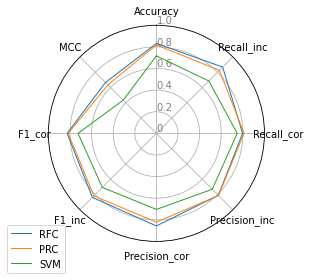

In [24]:
plot_radar(df_metrics_balanced,"Radar_plot_metrics_balanced")

r RFC
g PRC
b SVM


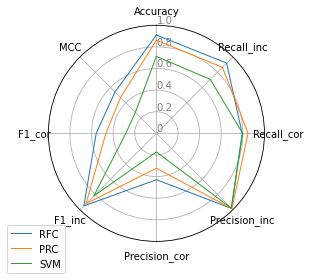

In [25]:
plot_radar(df_metrics_unbalanced,"Radar_plot_metrics_unbalanced")

# from google.colab import files
# files.download( "data/Radar_plot_metrics_balanced.svg" ) 
# files.download( "data/Radar_plot_metrics_unbalanced.svg" )

In [26]:
X_train = all_balanced_data[~all_balanced_data["idx"].isin(PDB_BM5) ]
y_train = all_balanced_data[~all_balanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')
X_validation = all_balanced_data[all_balanced_data["idx"].isin(PDB_BM5) ]
y_validation = all_balanced_data[all_balanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')

scaler = StandardScaler( )
scaler.fit(X_train.drop(feat_object,axis=1))

X_train_scaled = scaler.transform(X_train.drop(feat_object,axis=1))
X_validation_scaled = scaler.transform(X_validation[X_train.drop(feat_object,axis=1).columns])

rfc = train_model( 'RandomForest', X_train_scaled ,y_train)

In [27]:
## forward selection 
FS = []
thresholds = importance_by_train["Imp Train:BM4"]
for thresh in thresholds:
  # select features using threshold
  selection = SelectFromModel(rfc, threshold=thresh, prefit=True)
  select_X_train = selection.transform(X_train_scaled)
  
  # train model
  model = RandomForestClassifier(n_jobs=-1 ,n_estimators=100, random_state=32 )
  model.fit(select_X_train ,y_train)
  # eval model
  select_X_val = selection.transform(X_validation_scaled)
  # print (select_X_train.shape,thresh, select_X_val.shape)
  predictions = model.predict(select_X_val)
  results_rfc = save_metrics_results(model, select_X_val , y_validation,"RFC")
  accuracy = results_rfc['Accuracy']
  mcc = results_rfc['MCC']
  FS.append((thresh, select_X_train.shape[1], accuracy,mcc))
  # print("Thresh=%.3f, n=%d, Accuracy: %.2f%%, MCC: %.4f%" % (thresh, select_X_train.shape[1], accuracy*100.0,mcc ))

In [28]:
## forward selection 
FS_CV = []
thresholds = importance_by_train["Imp CV BM5"]
for thresh in thresholds:
  # select features using threshold
  selection = SelectFromModel(rfc, threshold=thresh, prefit=True)
  select_X_train = selection.transform(X_train_scaled)
  
  # train model
  model = RandomForestClassifier(n_jobs=-1,n_estimators=100 , random_state=32 )
  model.fit(select_X_train ,y_train)
  # eval model
  select_X_val = selection.transform(X_validation_scaled)
  # print (select_X_train.shape,thresh, select_X_val.shape)
  predictions = model.predict(select_X_val)
  results_rfc = save_metrics_results(model, select_X_val , y_validation,"RFC")
  accuracy = results_rfc['Accuracy']
  mcc = results_rfc['MCC']
  FS_CV.append((thresh, select_X_train.shape[1], accuracy,mcc))
  # print("Thresh=%.3f, n=%d, Accuracy: %.2f%%, MCC: %.4f%" % (thresh, select_X_train.shape[1], accuracy*100.0,mcc ))

In [29]:
Fs_CV = []
for m in FS_CV:
  Fs_CV.append((m[0],m[1],m[2]["RFC"],m[3]["RFC"]))
Fs= []
for m in FS:
  Fs.append((m[0],m[1],m[2]["RFC"],m[3]["RFC"]))

In [30]:
df_threshold = pd.DataFrame(Fs, columns=['I','N','Acc','MCC'])
df_threshold_CV = pd.DataFrame(Fs_CV, columns=['I','N','Acc','MCC'])

In [39]:
import seaborn as sns

In [40]:
def plot_FS_N(dataframe,title):
    my_list = []
    for m ,n in zip ( dataframe.N.values.tolist(), dataframe.MCC.values.tolist()):
        my_list.append((m,n,"MCC"))
    for m,n in zip ( dataframe.N.values.tolist() , dataframe.Acc.values.tolist()):
        my_list.append((m,n,"Acc"))

    df_my_list = pd.DataFrame(my_list,columns=['N','Value','Metric'])
    f= sns.scatterplot(data=df_my_list.sort_values(by="N"),hue="Metric",x="N",y="Value")
#     f.set(xlim=(1, 160 ))
    plt.savefig(f"../figures/{title}.svg",dpi=300,transparent=True,format="svg")
    return f


<AxesSubplot:xlabel='N', ylabel='Value'>

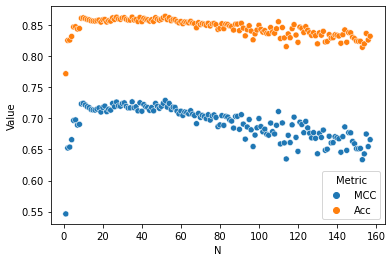

In [41]:
plot_FS_N(df_threshold,"scatter_plot_FS_bm5_N")

<AxesSubplot:xlabel='N', ylabel='Value'>

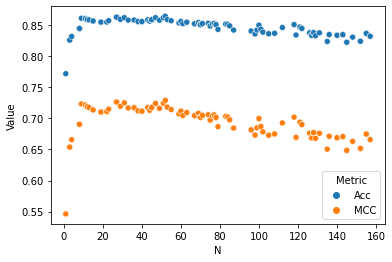

In [42]:
plot_FS_N(df_threshold_CV,"scatter_plot_FS_CV_N")

In [43]:
def plot_FS_T(dataframe,title):
    my_list = []
    for m ,n in zip ( dataframe["I"].values.tolist(), dataframe.MCC.values.tolist()):
        my_list.append((m,n,"MCC"))
    for m,n in zip ( dataframe["I"].values.tolist() , dataframe.Acc.values.tolist()):
        my_list.append((m,n,"Acc"))

    df_my_list = pd.DataFrame(my_list,columns=['I','Value','Metric'])
    f= sns.scatterplot(data=df_my_list.sort_values(by="I"),hue="Metric",x="I",y="Value")
    f.set(xlim=(0, 0.03))
    plt.savefig(f"../figures/{title}.svg",dpi=300,transparent=True,format="svg")
    return f

<AxesSubplot:xlabel='I', ylabel='Value'>

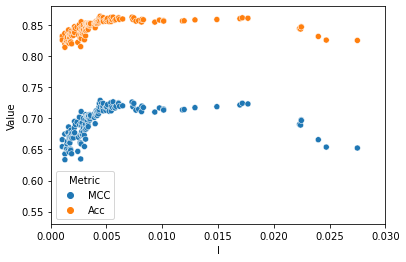

In [44]:
plot_FS_T(df_threshold,"scatter_plot_FS_bm5_T")

<AxesSubplot:xlabel='I', ylabel='Value'>

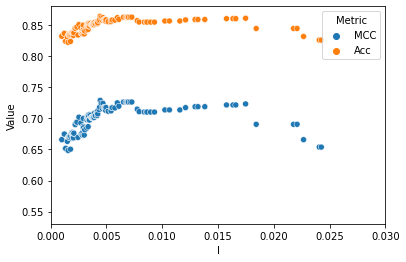

In [45]:
plot_FS_T(df_threshold_CV,"scatter_plot_FS_CV_T")

In [46]:
df_threshold.sort_values(by="I",ascending=False).head(n=20)

,I,N,Acc,MCC
46,0.205553,1,0.771800,0.546278
17,0.027491,2,0.825323,0.652284
85,0.024703,3,0.825881,0.653774
51,0.023990,4,0.831735,0.665667
100,0.022467,5,0.846956,0.696585
65,0.022461,6,0.847402,0.697522
69,0.022400,7,0.843611,0.689176
123,0.022311,8,0.844558,0.690417
103,0.017685,9,0.861062,0.723203
81,0.017183,10,0.861731,0.724318
